# Analyzing NIH grant abstracts to predict total funds awarded

Our goal is to predict how much funding a grant is awarded based on the grant abstract and the number of years a grant is funded. The code to obtain these data and perform initial cleaning can be found [here](download-clean-data.ipynb).

In this notebook we will perform initial exploration of the grants with abstract entries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[Local functions](https://github.com/yuwie10/nih-awards/blob/master/nih_functions.py) for this project.

In [2]:
import nih_functions as nih
import importlib as imp
imp.reload(nih);

To specify the dtypes on import, let's first import a single row and examine the columns.

In [3]:
cols = pd.read_csv('for_analysis.csv', compression = 'gzip', nrows = 1)
cols

,application_id,activity,application_type,arra_funded,funding_mechanism,fy,nih_spending_cats,phr,project_start,project_end,project_terms,study_section,study_section_name,support_year,funds,pi_ids,num_pis
0,6258248,c06,1,NaN,NaN,2000,NaN,NaN,2000-09-22,NaN,NaN,strb,scientific and technical review board on biome...,1,1488000.0,1860776,1.0


In [4]:
dates = ['project_start', 'project_end']
numeric = ['funds', 'support_year', 'num_pis']

#get dtypes
dtypes = nih.get_dtypes(cols, numeric)

grants = pd.read_csv('for_analysis.csv', compression = 'gzip',
                    dtype = dtypes, parse_dates = dates)

There are many different types of grants, including institutional training grants and contracts. For this analysis, we are only interested in individual research grants (see [here](https://grants.nih.gov/grants/funding/funding_program.htm) for more details). Let's begin with R01 grants, which are the main research grants that fund academic labs. We can then extend this analysis to other types of grants such as R21s (smaller, exploratory grants), K99/R00s (grants for individuals to transition from postdoc to principal investigator) and pre- and post-doctoral grants.

In [5]:
r01s = grants.ix[grants['activity'] == 'r01']
r01s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517427 entries, 40104 to 1446253
Data columns (total 17 columns):
application_id        517427 non-null object
activity              517427 non-null object
application_type      517427 non-null object
arra_funded           250790 non-null object
funding_mechanism     250790 non-null object
fy                    517427 non-null object
nih_spending_cats     234269 non-null object
phr                   191126 non-null object
project_start         517420 non-null datetime64[ns]
project_end           100571 non-null datetime64[ns]
project_terms         498529 non-null object
study_section         516041 non-null object
study_section_name    515749 non-null object
support_year          517427 non-null float64
funds                 513853 non-null float64
pi_ids                517427 non-null object
num_pis               517427 non-null float64
dtypes: datetime64[ns](2), float64(3), object(12)
memory usage: 71.1+ MB


Most R01s do not have an abstract (public health relevance (phr) statement, also formerly known as the project narrative) associated with the submission. In fact, only grants from 2008 and later have a non-missing entry for phr. Prior to 2008 the NIH either did not ask for this field or the entries were not entered into the database. As we would like to analyze NIH grants based on text data, we will filter out grants without abstract entries. There is also a key words entry (project_terms) that, although not as rich as the text data in phr, may also be useful, especially if these key words can be compared with key words from grants with a listed abstract. We will save those observations with project_terms in a separate dataframe as well.

In [6]:
key_words = r01s.ix[r01s['project_terms'].notnull()]
phr = r01s.ix[r01s['phr'].notnull()]

Let's look at the type of applications in our dataset, descriptions of which we list below (information scraped in [this](scrape-grant-info.ipynb) notebook).

In [8]:
nih.view_col_info('app_types.csv', col_name = 'type')

,type,stage,description
0,1,New,Initial request for support of a project that has not yet been funded.
1,2,Renewal,"Initial request for additional funding for a period subsequent to that provided by a current award. Renewal applications compete for funding with all other peer reviewed applications and must be developed as fully as though the applicant is applying for the first time. (Previously referred to as “competing continuation.”) If your renewal and subsequent resubmission of renewal application are not funded, you must use the ""new"" application type to compete for additional funding and continuity with your previous award will not be retained."
2,3,Competing Revision,"Initial request for (or the award of) additional funds during a current project period to support new or additional activities that are not identified in the current award. This request reflects an expansion of the scope of the grant-approved activities. Competitive revisions require peer review. (Competing revision replaces the previous NIH term, ""competing supplement."") An administrative supplement is a request for (or the award of) additional funds during a current project period to provide for an increase in costs due to unforeseen circumstances. All additional costs must be within the scope of the peer reviewed and approved project."
3,4,Extension,Request for additional years of support beyond the years previously awarded. (Used only for select programs.)
4,5,Noncompeting Continuation,Request or award for a subsequent budget period within a previously approved project for which a recipient does not have to compete with other applications.
5,6,Change of Organization Status (Successor-in-Interest),"Process whereby the rights to and obligations under an NIH grant(s) are acquired incidental to the transfer of all of the assets of the grantee or the transfer of that part of the assets involved in the performance of the grant(s). May result from legislative or other legal action, such as a merger or other corporate change."
6,7,Change of Grantee or Training Institution,Transfer of the legal and administrative responsibility for a grant-supported project or activity from one legal entity to another before the completion date of the approved project period (competitive segment).
7,8,Change of Institute or Center,Change of awarding NIH institute or center for the noncompeting continuation (Type 5).
8,9,Change of Institute or Center,Change of awarding NIH institute or center for the renewal (Type 2).


In [18]:
phr['application_type'].value_counts()

5    115357
1     38084
2     14578
3      9687
4      8261
7      4223
6       634
9       262
8        40
Name: application_type, dtype: int64

Interestingly most grants fall into the non-competing continuation category; the second largest category are new grants, as expected.

Let's look at basic summary statistics of our quantitative variables.

In [11]:
phr.describe()

,support_year,funds,num_pis
count,191126.000000,1.901460e+05,191126.000000
mean,5.556905,3.448723e+05,1.344077
std,6.381470,1.924590e+05,0.702543
min,1.000000,0.000000e+00,1.000000
25%,2.000000,2.513270e+05,1.000000
50%,3.000000,3.328415e+05,1.000000
75%,6.000000,3.993470e+05,2.000000
max,60.000000,8.046691e+06,9.000000


As expected, most R01s on average are funded for about 5 years, although the median number of years is only 3, and one grant has been funded for 60 years. Also as expected most grants are only associated with a single principal investigator (PI), or researcher. In the funding category we see that the minimum funding is 0, which suggests some grant information was incorrectly entered.

We plot the distributions of funds below.

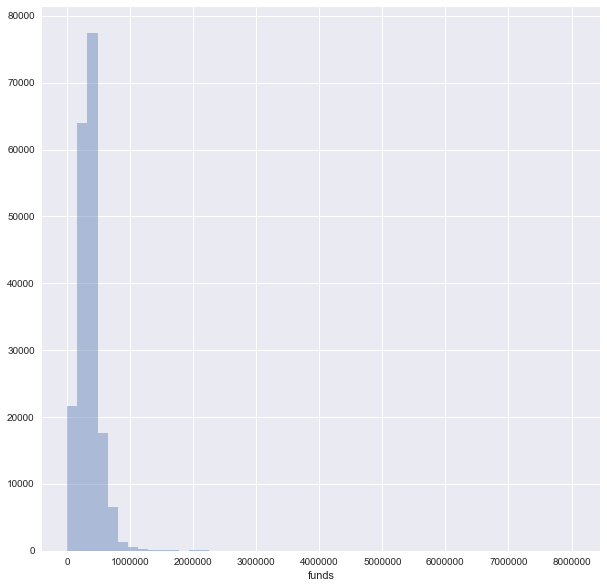

In [12]:
to_plot = phr.ix[phr['funds'] != 0]
to_plot = to_plot['funds'].dropna()

fig, _ = plt.subplots()
fig.set_size_inches(10, 10)
_ = sns.distplot(to_plot, kde = False)

Most grants were awarded less than $1,000,000 but there are a number awarded very large amounts. Let's plot these two groups separately so we can see the individual distributions more easily.

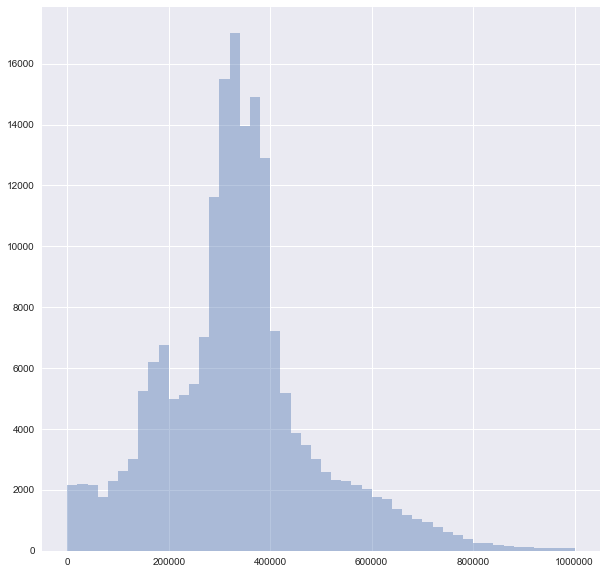

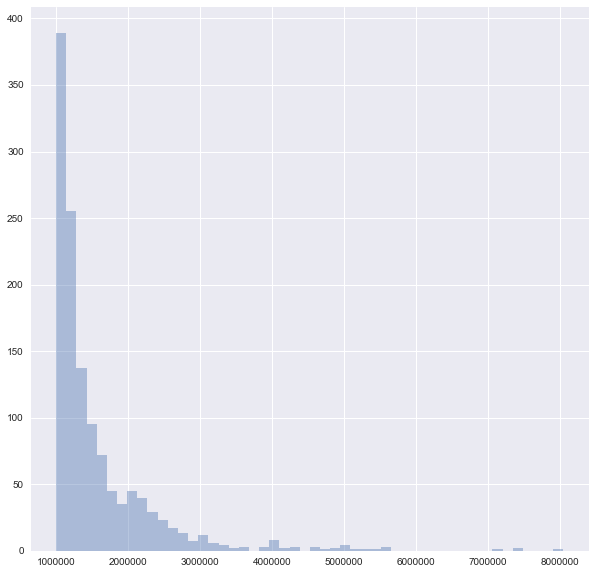

In [13]:
plot1 = []
plot2 = []
for funds in phr['funds'].dropna():
    if funds <= 1000000:
        plot1.append(funds)
    else:
        plot2.append(funds)

fig, _ = plt.subplots()
fig.set_size_inches(10, 10)
_ = sns.distplot(plot1, kde = False)

fig, _ = plt.subplots()
fig.set_size_inches(10, 10)
_ = sns.distplot(plot2, kde = False)

In [17]:
print('There are {} grants that received less than $1,000,000 and only {} that received more than that.'\
     .format(len(plot1), len(plot2)))

There are 188881 grants that received less than $1,000,000 and only 1265 that received more than that.


In [18]:
phr.to_csv('phr.csv', index = False, compression = 'gzip')

We will perform text analysis and predict grant funding in [this](abstracts-clustering-prediction.ipynb) notebook.